# Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from tensorflow import keras

from keras import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

### Helper functions

In [3]:
# Split dataset to partitions according to window size

def split_dataset_by_window(dataset, window_size, start, end, step, split_mode):
    sub_arrays = []

    n_samples = dataset.shape[0]
    n_timesteps = dataset.shape[1]
    n_steps = int(n_timesteps / window_size)

    for i in range(n_samples):
      # Sets the initial boundary of columns for the current range
      if split_mode == 2:
        col_start = 1
      else:
        col_start = 0

      for j in range(n_steps):
          # Sets the final boundary of columns for the current range
          col_end = col_start + window_size

          if split_mode == 1:
            col_end += 1

          # Slices the dataset using the limits defined above
          sub_array = dataset[i, col_start:col_end, start:end:step]

          # Updates col_start
          if split_mode == 1:
            col_start = col_end - 1
          else:
            col_start = col_end

          sub_arrays.append(sub_array)
          np.concatenate(sub_arrays, axis=0)

    return np.array(sub_arrays)

In [4]:
# Split dataset to TRAIN, VALIDATION and TEST sets
# The first dimension will be a multiple of
# the number of partitions for plotting reasons
#   TRAIN: about 70% of dataset
#   VALIDATION: about 20% of dataset
#   TEST: about 10% of dataset

def split_dataset(dataset, n_partitions, p_train=0.7, p_val=0.20, p_test=0.10):
    dim_1 = dataset.shape[0]
    dim_2 = dataset.shape[1]
    dim_3 = dataset.shape[2]

    size_1 = int(dim_1 * p_train) // n_partitions * n_partitions
    size_2 = int(dim_1 * p_val) // n_partitions * n_partitions
    size_3 = int(dim_1 * p_test) // n_partitions * n_partitions

    subarrays = [np.empty((size_1, dim_2, dim_3)) for i in range(3)]

    subarrays[0] = dataset[:size_1, :, :]
    subarrays[1] = dataset[size_1:size_1+size_2, :, :]
    subarrays[2] = dataset[size_1+size_2:size_1+size_2+size_3, :, :]

    return subarrays

In [5]:
# Define normalization type
# 0: MinMaxScaler
# 1: StandardScaler
# 2: RobustScaler
# 3: Custom Scaler (divides by dataset average)
# Check official doc for more info

def scaler(data, norm_type=0):
  if norm_type == 0:
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler
  elif norm_type == 1:
    scaler = StandardScaler()
    return scaler.fit_transform(data), scaler
  elif norm_type == 2:
    scaler = RobustScaler()
    return scaler.fit_transform(data), scaler
  elif norm_type == 3:
    max = np.amax(data)
    min = np.amin(data)

    scaler = (max + min) / 2
    data = data / scaler
    return data, scaler

In [6]:
# Plot epoch history

def plot_epoch_history(history):
  font = {
    'family': 'serif',
    'color':'darkblue',
    'weight':'normal',
    'size': 14
  }

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(6, 4))

  plt.xlabel('Epoch', fontdict=font)
  plt.ylabel('Mean Squared Error', fontdict=font)

  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')

  plt.legend()
  plt.grid()

  plt.show()

In [7]:
# Plot partitions side by side

def plot_partitions(time, data, start, end, window_size, split_mode, estilo, cor):
  time_start = 0

  for i in range(start, end):
    time_end = time_start + window_size

    if split_mode == 1:
      time_end += 1

    plt.plot(time[time_start:time_end], data[i, :], estilo, c=cor)
    plt.axvline(time[time_start], color='g', linestyle='--')

    if split_mode == 1:
      time_start = time_end - 1
    else:
      time_start = time_end

In [8]:
def plot_results(data_expected, data_predicted, timestep_size, n_partitions,
                 window_size, well_index, well_type, well_output, split_mode, sample_index=None):
  # Define plot styles
  font = {
      'family': 'serif',
      'color':'darkblue',
      'weight':'normal',
      'size': 16
  }

  # Get number of plots
  if data_expected.ndim == 1:
    n_test_samples = 1
  else:
    n_test_samples = data_expected.shape[0]

  n_plots = n_test_samples // n_partitions

  # Set horizontal axis data
  time_horizon = timestep_size * window_size * n_partitions
  time = np.arange(0, time_horizon + timestep_size, timestep_size)

  # Plot figure
  col_start = 0

  for i in range(n_plots):
    col_end = col_start + n_partitions

    plt.figure(figsize = (6, 4))

    plot_partitions(time, data_expected, col_start, col_end, window_size, split_mode, 'o-', 'b')
    plot_partitions(time, data_predicted, col_start, col_end, window_size, split_mode, '*-', 'r')

    if (n_partitions == 1):
      plt.legend(handles=[plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='blue', markeredgecolor='blue', label='Expected'),
                          plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='red', markeredgecolor='red', label='Predicted')],
                 loc='upper right', handlelength=0,
                 shadow=True, fontsize='x-large')
    else:
      plt.legend(handles=[plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='blue', markeredgecolor='blue', label='Expected'),
                          plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='red', markeredgecolor='red', label='Predicted'),
                          plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='green', markeredgecolor='green', label='Partition Border')],
                 loc='upper right', handlelength=0,
                 shadow=True, fontsize='x-large')

    if sample_index == None:
      test_index = i
    else:
      test_index = sample_index

    if well_type == 0:
      if well_output == 'ir':
        plt.title(f'Water Rate I-{well_index}, Test-{test_index+1}', fontdict=font)
        plt.ylabel('Psi', fontdict=font)
        plt.ylim([0, 1100])
    elif well_type == 1:
      if well_output == 'lr':
        plt.title(f'Liquid Rate P-{well_index}, Test-{test_index+1}', fontdict=font)
        plt.ylabel('bbl/day', fontdict=font)
        plt.ylim([0, 4500])
      elif well_output == 'ir':
        plt.title(f'BHP I-{well_index}, Test-{test_index+1}', fontdict=font)
        plt.ylabel('Psi', fontdict=font)
        plt.ylim([0, 1100])
    elif well_type == 2:
      if well_output == 'or':
        plt.title(f'Oil Rate P-{well_index}, Test-{test_index+1}', fontdict=font)
        plt.ylabel('bbl/day', fontdict=font)
        plt.ylim([0, 1000])
      elif well_output == 'wr':
        plt.title(f'Water Rate P-{well_index}, Test-{test_index+1}', fontdict=font)
        plt.ylabel('bbl/day', fontdict=font)
        plt.ylim([0, 2500])
      elif well_output == 'ir':
        plt.title(f'BHP I-{well_index}, Test-{test_index+1}', fontdict=font)
        plt.ylabel('Psi', fontdict=font)
        plt.ylim([39000, 47000])
    elif well_type == 3:
      if well_output == 'ir':
        plt.title(f'BHP I-{well_index}, Test-{test_index+1}', fontdict=font)
        plt.ylabel('Psi', fontdict=font)
        plt.ylim([0, 1100])

    plt.xlabel('Time (days)', fontdict=font)
    plt.xlim([0, time_horizon+20])

    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20

    plt.grid()
    plt.show()

    col_start = col_end

In [9]:
def printFeatOutput():
  print()
  print("Feature output: {}".format(i+1))

  if window_size == 6:
    yhatE = Ay_hatE[:, :, i]
    ytest = Ay_test[:, :, i]
  else:
    yhatE = y_hat[:, :, i]
    ytest = y_test[:, :, i]

  #print(yhatE.shape,ytest.shape)
  vec=np.zeros((y_hat.shape[0], 1))

  for j in range(ytest.shape[0]):
    score = np.sqrt(metrics.mean_squared_error(yhatE[j, :], ytest[j, :]))
    #print("Amostra " +str(j+1)," --> Final score (RMSE) {}: ".format(score))
    vec[j, 0] = score

  def erro_mais_proximo(num, vetor):
      diferenca = abs(num - vetor[0])
      index = 0
      for k in range(1, len(vetor)):
          if abs(num - vetor[k]) < diferenca:
              diferenca = abs(num - vetor[k])
              index = k
      return index, vetor[index]

  erro_index = erro_mais_proximo(score_mean, vec)
  print("Amostra " + str(erro_index[0] + 1)," --> Final score (RMSE): {}".format(erro_index[1]))

  return erro_index

In [10]:
def find_by_average_error(value, data):
    result = data[0]
    index = 0

    for i, element in enumerate(data):
        if abs(element - value) < abs(result - value):
            result = element
            index = i

    return result, index

# Preprocess Dataset

## Load Database

In [11]:
# numero de produtores

n_prod=4

# numero de injetores

n_inj=8


# define input to injetor wells--> bhp or rate

type_control_inj='rate'


In [12]:
dbase = np.load('/content/drive/MyDrive/Colab Notebooks/EggDataset_bhp_rate_full_projeto.npy')

db=dbase[0:1463,:,:]
print( db.shape)

(1463, 60, 32)


## Split dataset into partitions

In [13]:
# Define parameters


# define 0 to full injector rate wells;
# 1 to Liquid/Injetion rate wells;
# 2 to Oil/WaterP/WaterI
# 3 to one injector

well_type=2



n_timesteps = db.shape[1]
window_size =59
n_partitions = n_timesteps // window_size

print(n_timesteps, window_size, n_partitions)

60 59 1


In [14]:
# Set split mode
# 0: normal partition (ignore last step)
# 1: partition with overlap
# 2: normal partition (ignore first step)

split_mode = 1

In [15]:
# Inputs: Wells' BHP

prod_bhp = split_dataset_by_window(db, window_size, 0, 4*n_prod, 4, split_mode)

if type_control_inj=='bhp':
  inj_bhp = split_dataset_by_window(db, window_size, 4*n_prod, None, 2, split_mode)
elif type_control_inj=='rate':
  inj_bhp = split_dataset_by_window(db, window_size, 4*n_prod+1, None, 2, split_mode)

X = np.concatenate((prod_bhp, inj_bhp), axis = 2)

# Apply custom normalization
X, _ = scaler(X, 3)

print(prod_bhp.shape, inj_bhp.shape, X.shape)

(1463, 60, 4) (1463, 60, 8) (1463, 60, 12)


In [16]:
# Outputs


# Producer Wells' oil Rate
y1 = split_dataset_by_window(db, window_size, 2, 4*n_prod, 4, split_mode)
prod_qwr_size = y1.shape[2]

# Producer Wells' water Rate
y2 = split_dataset_by_window(db, window_size, 3, 4*n_prod, 4, split_mode)
prod_qor_size = y2.shape[2]

# Injector Wells' Water Rate
if type_control_inj=='bhp':
  y3 = split_dataset_by_window(db, window_size, 4*n_prod+1, None, 2, split_mode)
elif type_control_inj=='rate':
  y3 = split_dataset_by_window(db, window_size, 4*n_prod, None, 2, split_mode)

inj_qwr_size = y3.shape[2]

y = np.concatenate((y1, y2, y3), axis = 2)

# Reshape to apply normalization
y_reshaped = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
y_reshaped, sc = scaler(y_reshaped)

# Restore original dimension
y = y_reshaped.reshape(y.shape[0], y.shape[1], y.shape[2])

print(y.shape)

(1463, 60, 16)


In [17]:
# Split datasets

X_train, X_val, X_test = split_dataset(X, n_partitions)
y_train, y_val, y_test = split_dataset(y, n_partitions)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1024, 60, 12) (292, 60, 12) (146, 60, 12)
(1024, 60, 16) (292, 60, 16) (146, 60, 16)


# Build Model

In [18]:
# Adittional paramaters

n_steps_in = X.shape[1]
n_features_in = X.shape[2]

n_steps_out = y.shape[1]
n_features_out = y.shape[2]

print(n_steps_in, n_features_in)
print(n_steps_out, n_features_out)

60 12
60 16


In [19]:
# Define model

inputs = Input(shape=(n_steps_in, n_features_in))
#layer1 = LSTM(192, activation='relu')(inputs)
#repeat = tf.keras.layers.RepeatVector(n_steps_out)(layer1)
layer2 = LSTM(192, activation='relu', return_sequences=True)(inputs)
output = tf.keras.layers.TimeDistributed(Dense(n_features_out))(layer2)  # Use layer2 instead of layer1
model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008), loss='mse')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 12)]          0         
                                                                 
 lstm (LSTM)                 (None, 60, 192)           157440    
                                                                 
 time_distributed (TimeDist  (None, 60, 16)            3088      
 ributed)                                                        
                                                                 
Total params: 160528 (627.06 KB)
Trainable params: 160528 (627.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [20]:
# Define model

#inputs = Input(shape=(n_steps_in, n_features_in))
#layer1 = LSTM(192, activation='relu')(inputs)
#repeat = tf.keras.layers.RepeatVector(n_steps_out)(layer1)
#layer2 = LSTM(192, activation='relu', return_sequences=True)(repeat)
#output = tf.keras.layers.TimeDistributed(Dense(n_features_out))(layer2)  # Use layer2 instead of layer1
#model = tf.keras.Model(inputs=inputs, outputs=output)

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008), loss='mse')
#print(model.summary())

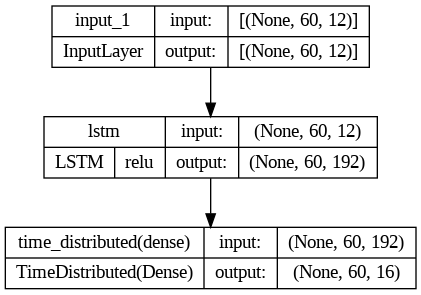

In [21]:
plot_model(model, show_shapes=True, show_layer_activations=True)

In [22]:
# Fit model

monitor = EarlyStopping(monitor='val_loss',
                        min_delta=1e-4,
                        patience=10,
                        verbose=2,
                        mode='auto',
                        restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    callbacks=[monitor],
                    verbose=1,
                    batch_size=256,
                    epochs=500,
                    validation_split=0.2)

Epoch 1/500
4/4 [==============================] - 3s 147ms/step - loss: 0.1568 - val_loss: 0.0872
Epoch 2/500
4/4 [==============================] - 0s 62ms/step - loss: 0.0630 - val_loss: 0.0379
Epoch 3/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0334 - val_loss: 0.0302
Epoch 4/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0282 - val_loss: 0.0255
Epoch 5/500
4/4 [==============================] - 0s 59ms/step - loss: 0.0239 - val_loss: 0.0224
Epoch 6/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0219 - val_loss: 0.0216
Epoch 7/500
4/4 [==============================] - 0s 53ms/step - loss: 0.0209 - val_loss: 0.0203
Epoch 8/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0194 - val_loss: 0.0187
Epoch 9/500
4/4 [==============================] - 0s 53ms/step - loss: 0.0179 - val_loss: 0.0175
Epoch 10/500
4/4 [==============================] - 0s 57ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 11/500
4/4 [

# Plot Results

## Epoch History

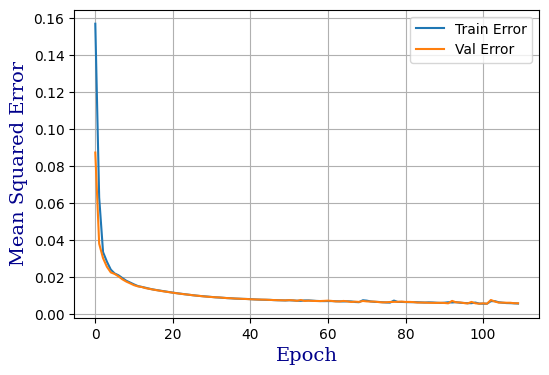

In [23]:
plot_epoch_history(history)

## Test dataset prediction

In [24]:
# Make prediction
y_hat = model.predict(X_test, verbose=0)

print(y_hat.shape)

# Reshape to remove normalization
y_hat0 = y_hat.reshape(y_hat.shape[0]* y_test.shape[1], y_test.shape[2])
y_test1 = y_test.reshape(y_hat.shape[0]* y_test.shape[1], y_test.shape[2])

print(y_hat0.shape, y_test1.shape)



(146, 60, 16)
(8760, 16) (8760, 16)


In [25]:
score_mean = np.sqrt(metrics.mean_squared_error(y_hat0, y_test1))
print("Final score mean (RMSE): {:.4f}".format(score_mean))



Final score mean (RMSE): 0.0750


In [26]:
y_hatE = y_hat[:, :, :]
ytest = y_test[:, :, :]

In [27]:
#if window_size == 6:
#  Ay_hatE=y_hatE.reshape(146,35,13)
#  Ay_test0=y_test.reshape(146,35,13)
#  print(Ay_test0.shape, Ay_hatE.shape)


In [28]:
## Calculate error

#print(y_hat.shape, y_test.shape)

feature_outputs = []

for i in range(n_features_out):
  feature_output = printFeatOutput()
  feature_outputs.append(feature_output)


Feature output: 1
Amostra 7  --> Final score (RMSE): [0.07290075]

Feature output: 2
Amostra 134  --> Final score (RMSE): [0.04977323]

Feature output: 3
Amostra 2  --> Final score (RMSE): [0.05360438]

Feature output: 4
Amostra 10  --> Final score (RMSE): [0.04205765]

Feature output: 5
Amostra 139  --> Final score (RMSE): [0.07482366]

Feature output: 6
Amostra 21  --> Final score (RMSE): [0.07519474]

Feature output: 7
Amostra 100  --> Final score (RMSE): [0.07442239]

Feature output: 8
Amostra 76  --> Final score (RMSE): [0.07515975]

Feature output: 9
Amostra 32  --> Final score (RMSE): [0.07459767]

Feature output: 10
Amostra 138  --> Final score (RMSE): [0.07496485]

Feature output: 11
Amostra 2  --> Final score (RMSE): [0.07430608]

Feature output: 12
Amostra 6  --> Final score (RMSE): [0.07673406]

Feature output: 13
Amostra 95  --> Final score (RMSE): [0.07431489]

Feature output: 14
Amostra 32  --> Final score (RMSE): [0.07515313]

Feature output: 15
Amostra 140  --> Final 

In [29]:
# Reshape to remove normalization

y_hat_reshaped = y_hatE.reshape(y_hatE.shape[0] * y_hatE.shape[1], y_hatE.shape[2])
y_hat_reshaped = sc.inverse_transform(y_hat_reshaped)

y_test_reshaped = y_test.reshape(y_test.shape[0] * y_test.shape[1], y_test.shape[2])
y_test_reshaped = sc.inverse_transform(y_test_reshaped)

# Restore original dimension

y_test = y_test_reshaped.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2])
y_hat = y_hat_reshaped.reshape(y_hat.shape[0], y_hat.shape[1], y_test.shape[2])

#print(y_test.shape)
#print(y_hat)

In [30]:
# Print only outputs which are closest to avg error

filter_by_avg_error = True

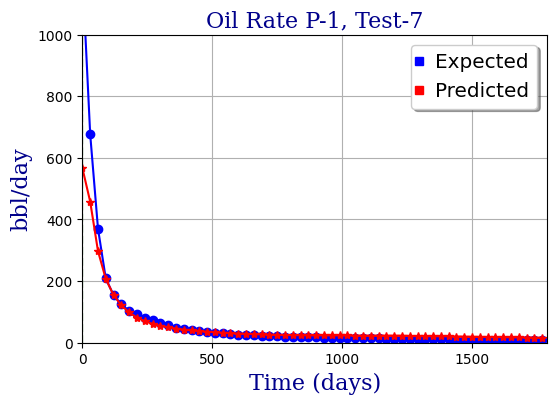

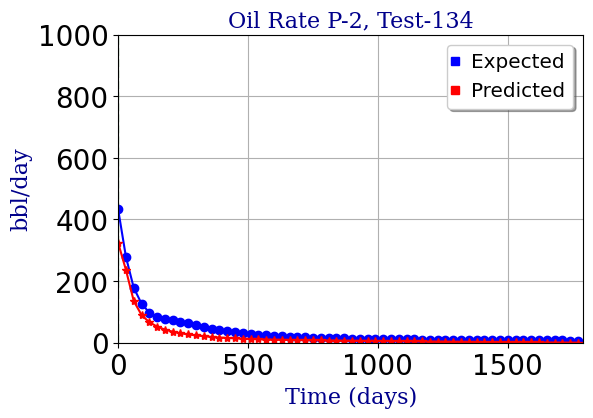

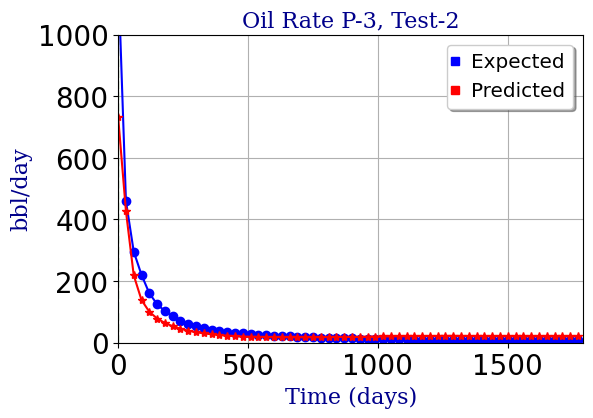

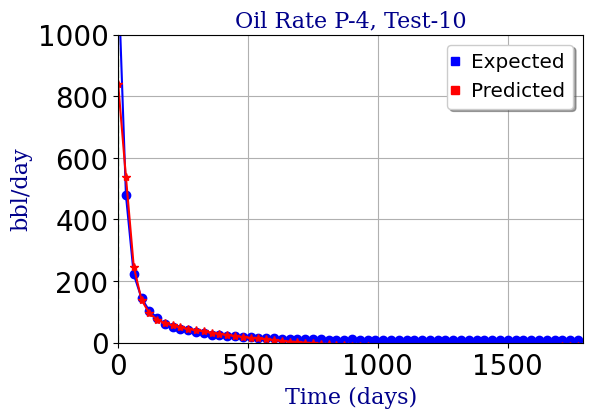

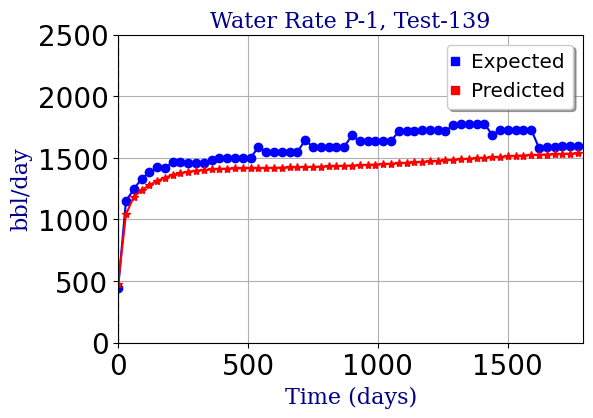

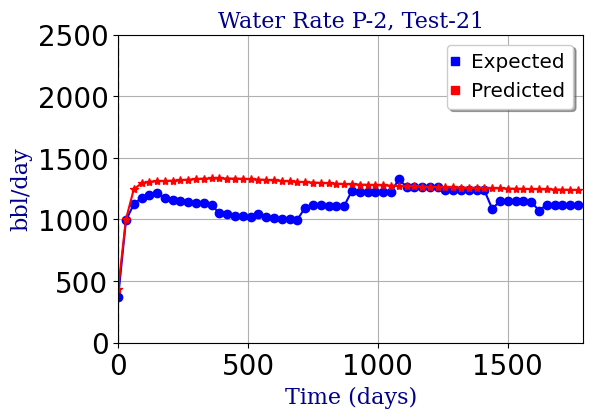

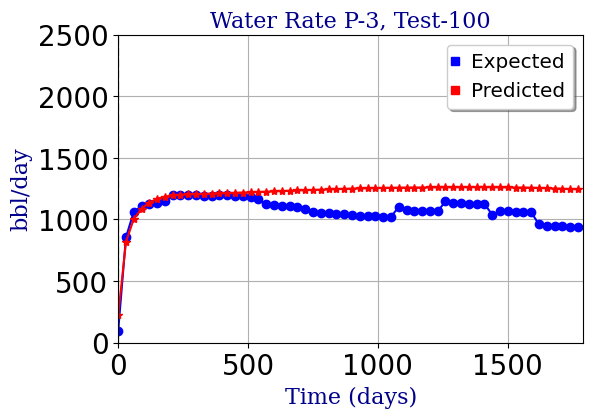

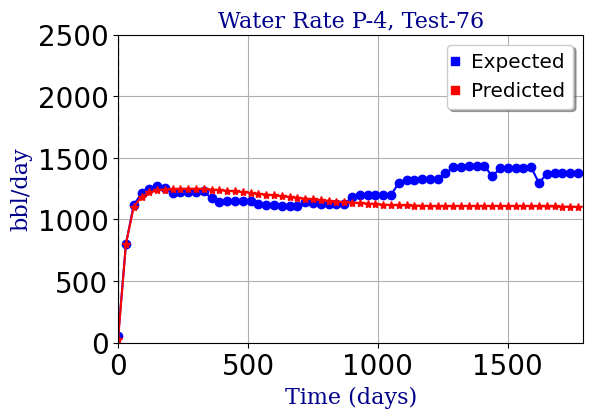

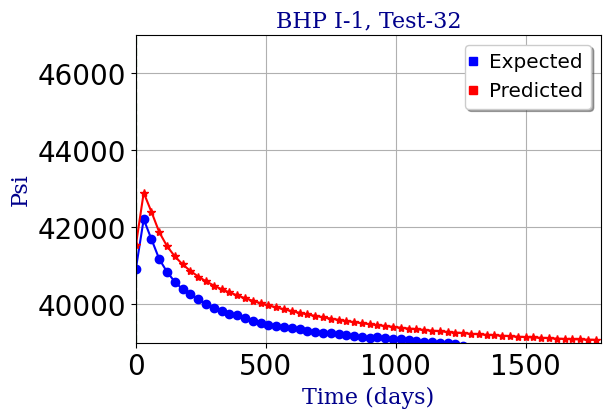

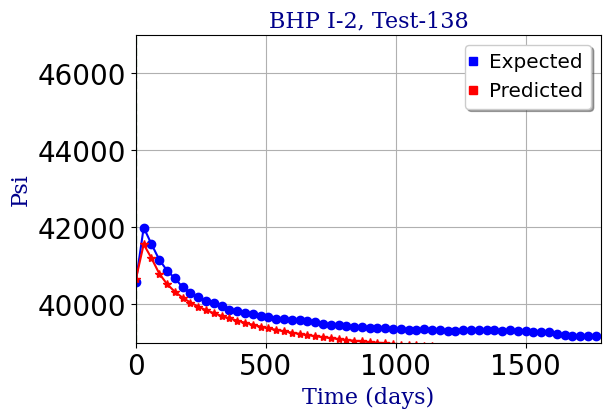

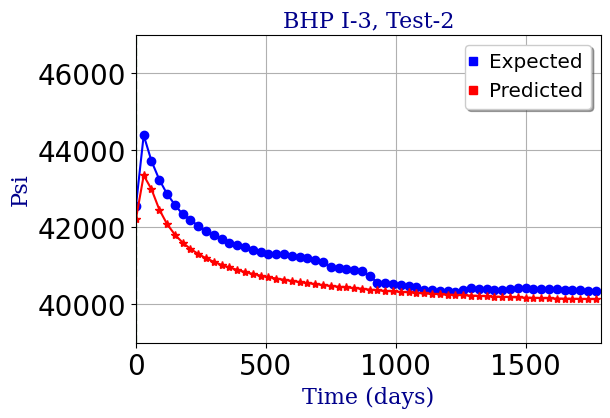

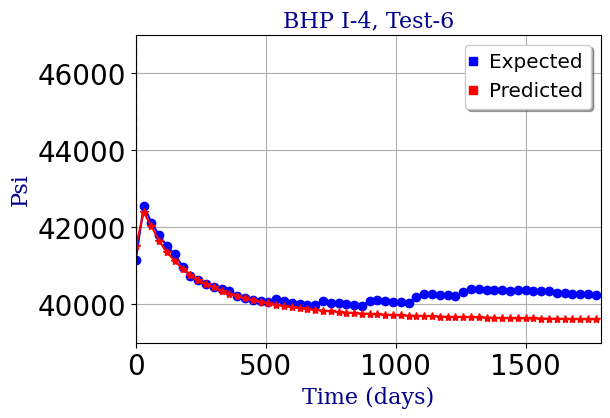

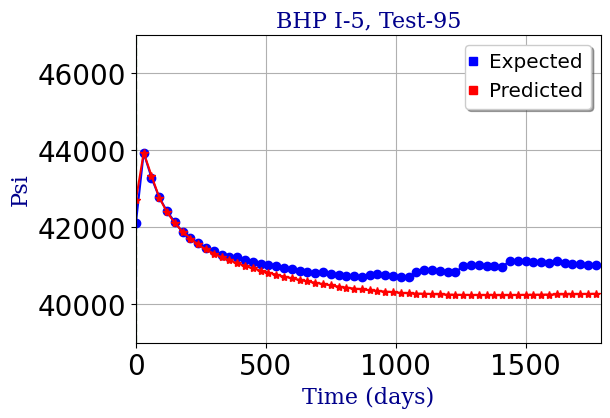

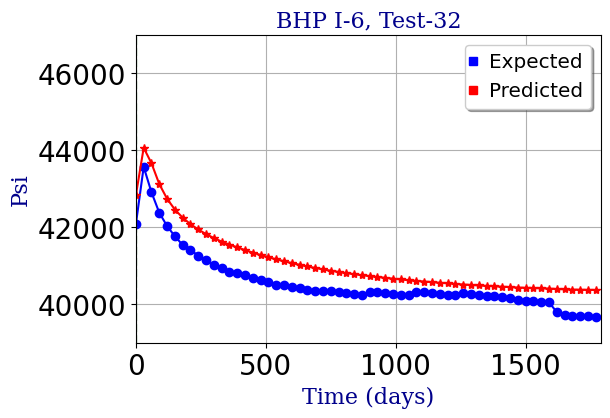

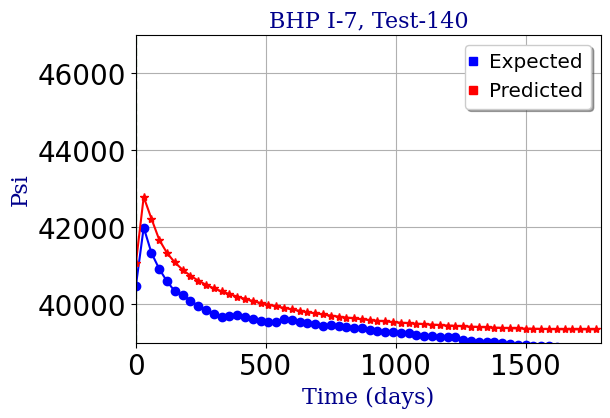

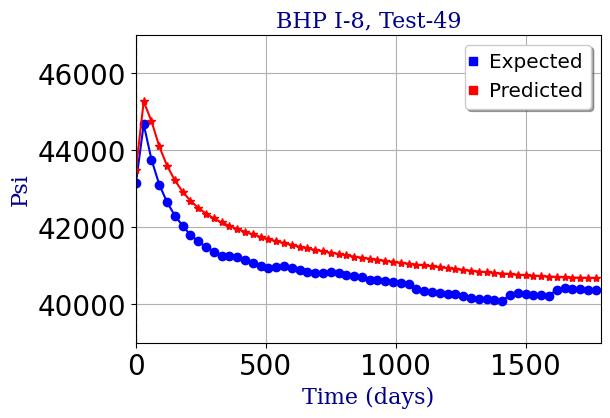

In [31]:
if well_type == 0:
  # Plot injector Wells' Water Rate

  data_expected = y_test[:, :, 0:inj_qwr_size]
  data_predicted = y_hat[:, :, 0:inj_qwr_size]

  score = np.sqrt(metrics.mean_squared_error(data_expected[:, i],data_predicted [:, i]))
  print(score)

  for i in range(inj_qwr_size):
    plot_results(data_expected[:, :, i], data_predicted[:, :, i], 30, n_partitions, window_size, i+1, well_type, 'ir', split_mode)

elif well_type == 1:
  # Plot Producer Wells' Liquid Rate

  data_expected = y_test[:, :, 0:prod_qlr_size]
  data_predicted = y_hat[:, :, 0:prod_qlr_size]

  for i in range(prod_qlr_size):
    if (filter_by_avg_error):
      plot_results(data_expected[feature_outputs[i][0], :, i].reshape(1, data_expected.shape[1]),
                  data_predicted[feature_outputs[i][0], :, i].reshape(1, data_predicted.shape[1]),
                  30, n_partitions, window_size, i+1, well_type, 'lr', split_mode, feature_outputs[i][0])
    else:
      plot_results(data_expected[:, :, i], data_predicted[:, :, i], 30, n_partitions, window_size, i+1, well_type, 'lr', split_mode)

  # Plot injector Wells' Water Rate

  data_expected = y_test[:, :, prod_qlr_size:]
  data_predicted = y_hat[:, :, prod_qlr_size:]

  for i in range(inj_qwr_size):
    if (filter_by_avg_error):
      plot_results(data_expected[feature_outputs[i+prod_qlr_size][0], :, i].reshape(1, data_expected.shape[1]),
                  data_predicted[feature_outputs[i+prod_qlr_size][0], :, i].reshape(1, data_predicted.shape[1]),
                  30, n_partitions, window_size, i+1, well_type, 'ir', split_mode, feature_outputs[i+prod_qlr_size][0])
    else:
      plot_results(data_expected[:, :, i], data_predicted[:, :, i], 30, n_partitions, window_size, i+1, well_type, 'ir', split_mode)

elif well_type == 2:
  # Plot Producer Wells' Oil Rate

  data_expected = y_test[:, :, 0:prod_qor_size]
  data_predicted = y_hat[:, :, 0:prod_qor_size]

  for i in range(prod_qor_size):
    if (filter_by_avg_error):
      plot_results(data_expected[feature_outputs[i][0], :, i].reshape(1, data_expected.shape[1]),
                  data_predicted[feature_outputs[i][0], :, i].reshape(1, data_predicted.shape[1]),
                  30, n_partitions, window_size, i+1, well_type, 'or', split_mode, feature_outputs[i][0])
    else:
      plot_results(data_expected[:, :, i], data_predicted[:, :, i], 30, n_partitions, window_size, i+1, well_type, 'or', split_mode)

  # Plot Producer Wells' Water Rate

  data_expected = y_test[:, :, prod_qor_size:prod_qor_size+prod_qwr_size]
  data_predicted = y_hat[:, :, prod_qor_size:prod_qor_size+prod_qwr_size]

  for i in range(prod_qwr_size):
    if (filter_by_avg_error):
      plot_results(data_expected[feature_outputs[i+prod_qor_size][0], :, i].reshape(1, data_expected.shape[1]),
                   data_predicted[feature_outputs[i+prod_qor_size][0], :, i].reshape(1, data_expected.shape[1]),
                   30, n_partitions, window_size, i+1, well_type, 'wr', split_mode, feature_outputs[i+prod_qor_size][0])
    else:
      plot_results(data_expected[:, :, i], data_predicted[:, :, i], 30, n_partitions, window_size, i+1, well_type, 'wr', split_mode)

  # Plot injector Wells' Water Rate

  data_expected = y_test[:, :, prod_qor_size+prod_qwr_size:]
  data_predicted = y_hat[:, :, prod_qor_size+prod_qwr_size:]

  for i in range(inj_qwr_size):
    if (filter_by_avg_error):
      plot_results(data_expected[feature_outputs[i+prod_qor_size+prod_qwr_size][0], :, i].reshape(1, data_expected.shape[1]),
                   data_predicted[feature_outputs[i+prod_qor_size+prod_qwr_size][0], :, i].reshape(1, data_expected.shape[1]),
                   30, n_partitions, window_size, i+1, well_type, 'ir', split_mode, feature_outputs[i+prod_qor_size+prod_qwr_size][0])
    else:
      plot_results(data_expected[:, :, i], data_predicted[:, :, i], 30, n_partitions, window_size, i+1, well_type, 'ir', split_mode)

elif well_type == 3:
  # Plot injector Wells' Water Rate

  data_expected = y_test[:, :, 0:inj_qwr_size]
  data_predicted = y_hat[:, :, 0:inj_qwr_size]

  plot_results(data_expected[:, :, 0], data_predicted[:, :, 0], 30, n_partitions, window_size, 1, well_type, 'ir', split_mode)